[View in Colaboratory](https://colab.research.google.com/github/shehzaan07/Advanced_linear_regression_house_price/blob/master/advanced_linear_regression_house_price.ipynb)

In [0]:
#Importing Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, kurtosis
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
get_ipython().run_line_magic('matplotlib', 'inline')

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#3. Read file as panda dataframe
import pandas as pd
test = pd.read_csv('gdrive/My Drive/test_class.csv')
train = pd.read_csv('gdrive/My Drive/train_class.csv')

In [0]:
#Data Overview

print ("Rows     : " ,train.shape[0])
print ("Columns  : " ,train.shape[1])
print ("\nFeatures : \n" ,train.columns.tolist())
print ("\nMissing values :  ", train.isnull().sum().values.sum())
print ("\nUnique values :  \n",train.nunique())

In [0]:
#Data Manipulation
train_ID = train["Id"] #saving id and unnamed 0
train_unnamed = train["Unnamed: 0"]

In [0]:
#dropping ID and Unnamed 0 column
train.drop(labels = ["Id","Unnamed: 0"], axis = 1, inplace = True)
train.head()

In [0]:
#Exploratory Data Analysis
sns.distplot(train["SalePrice"], bins = 20 , rug = True)

print("Skewness: %0.2f" %train["SalePrice"].skew())
print("Kurtosis: %0.2f" %train["SalePrice"].kurtosis())

In [0]:
# Corelation matrix
corrmat = train.corr()
plt.subplots(figsize = (20,9))
sns.heatmap(corrmat,vmax = 0.9, annot=True)

In [0]:
#focussing on features with correlation >=0.5
filtered_corr_mat_features = corrmat.index[abs(corrmat['SalePrice']>=0.5)]

In [0]:
plt.subplots(figsize = (12,12))
sns.heatmap(train[filtered_corr_mat_features].corr(),vmax = 0.9, annot=True, cmap = 'winter')
highly_corr_features = ['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars','GarageArea']

In [0]:
sns.pairplot(train[highly_corr_features], size =5,)

In [46]:
#Starting with actual preprocessing
n_train = train.shape[0]
y_train = train.SalePrice.values

train.head()
train.shape

(1168, 80)

In [0]:
#Preprocessing - Handling Missing Values
totalMissing = train.isnull().sum(axis=0).sort_values(ascending = False) #sum() only takes sum for those where isnull() returns true
totalCount = train.isnull().count(axis = 0).sort_values(ascending=False)
percent = ((totalMissing/totalCount)*100).sort_values(ascending = False)
missingValues = pd.concat([totalMissing,percent],axis = 1, keys = ["Total","Percent"])
missingValues = missingValues.sort_values(by = ["Percent","Total"], ascending = False)

In [0]:
#Preprocessing - Visualizing the missingValue
plt.subplots(figsize = (15,15))
sns.barplot(x = missingValues.index[:20], y = missingValues['Percent'][:20], data = missingValues)
plt.xticks(rotation = 90)
plt.xlabel("Features")
plt.ylabel("percentage of missing data")
plt.title("percentage of missing data by features")
plt.show()

In [57]:
# In[23]:
#Dropping the features which has more than 50% missing data
columnsToBeDropped = missingValues[missingValues['Percent']>=50].index
train = train.drop(columnsToBeDropped, axis = 1)


train.shape

(1168, 76)

In [0]:
# Identifying numerical and categorical features
category_col = train.select_dtypes(include=['object']).columns #Categorical 
numerical_col = train.select_dtypes(exclude=['object']).columns #numerical

In [0]:
#FireplaceQu : data description says Null means "no fireplace"
train['FireplaceQu'] = train['FireplaceQu'].fillna('None')

In [0]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [0]:
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there is no basement.
# GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 
            'BsmtFinType1', 'BsmtFinType2',
            'GarageType', 'GarageFinish', 'GarageQual', 
            'GarageCond'):
    train[col] = train[col].fillna('None')

In [0]:
#GarageYrBlt replacing missing data with 0
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)

In [0]:
train["MasVnrType"] = train["MasVnrType"].fillna("None")
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)

In [0]:
train.groupby(by='Electrical')['Electrical'].count()
train['Electrical'].mode()[0]

In [0]:
#Electrical : It has one NA value. 
#Since this feature has mostly 'SBrkr', we can set that for the missing value.
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

In [0]:
#Re-checking for null values in the dataset
train.isnull().sum().sort_values(ascending=False)

In [0]:
#SalePrice Correlation Matrix
k=10
sns.set(font_scale=1.5)
corrmat=train.corr()
cols = corrmat.nsmallest(k, 'SalePrice')['SalePrice'].index # fetching the column names for 10 lowest correlation values against SalePrice
print(cols)

In [0]:
Uncor = cols
train.drop(Uncor, axis=1, inplace=True)
train.info()

In [0]:
#More features engineering
#Transforming some numerical variables that are really
train['MoSold'] = train['MoSold'].astype(str)

In [0]:
# Adding total sqfootage feature 
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

In [0]:
#Removing outliers
from pandas.api.types import is_numeric_dtype
def remove_outliers(df):
    low = .05
    high = .9
    quant_df = df.quantile([low, high])
    for name in list(df.columns):
        if is_numeric_dtype(df[name]):
            df = df[(df[name] > quant_df.loc[low, name]) & (df[name] < quant_df.loc[high, name])]
    return df

remove_outliers(train).head()

In [0]:
#check the standardizing data
for name in list(train.columns):
    if is_numeric_dtype(train[name]):
        saleprice_scaled = StandardScaler().fit_transform(train[name][:,np.newaxis])

        low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:5]#[:,0] to exclude in the new dummy axis, argsort returns the index after sorting
        high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-5:]
        print('outer range (low) of the distribution:',name)
        print(low_range)
        print('\nouter range (high) of the distribution:',name)
        print(high_range)

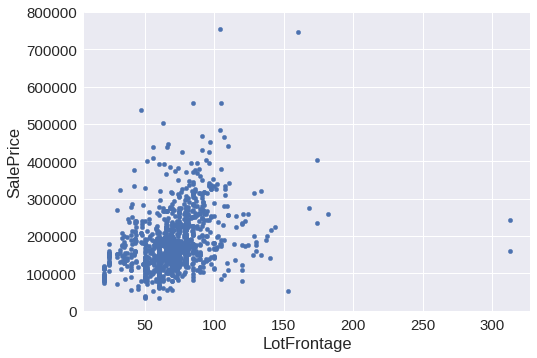

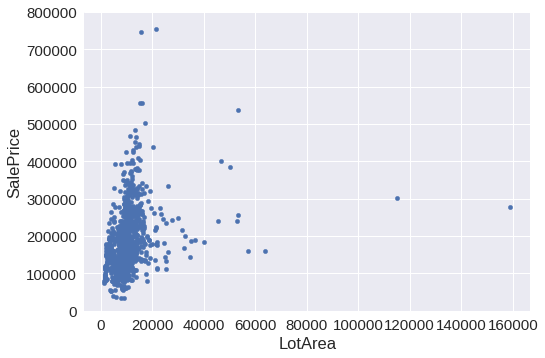

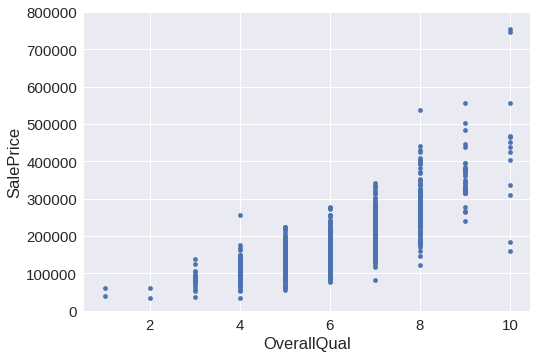

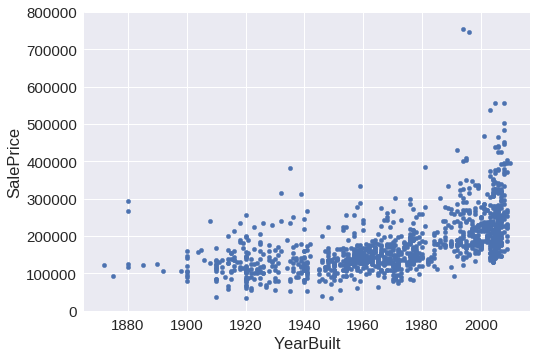

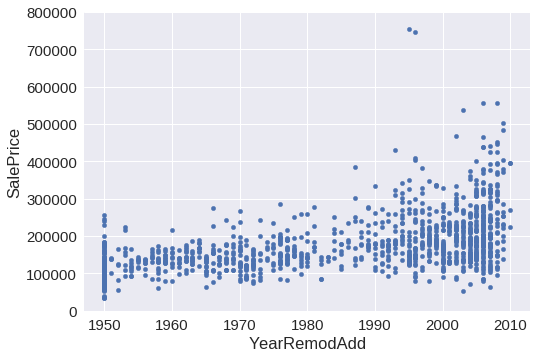

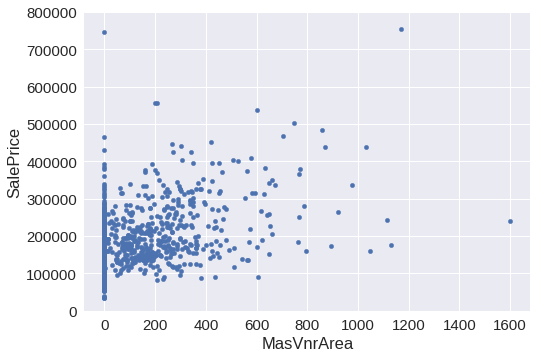

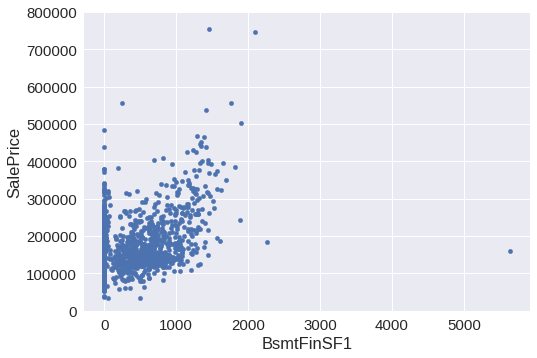

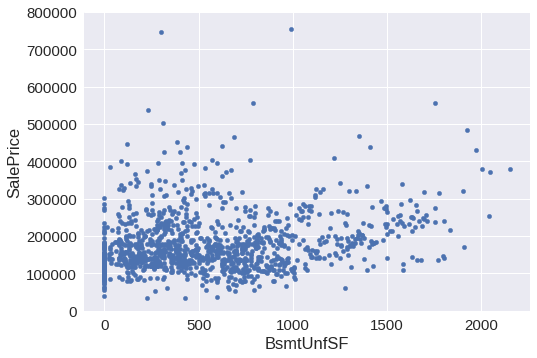

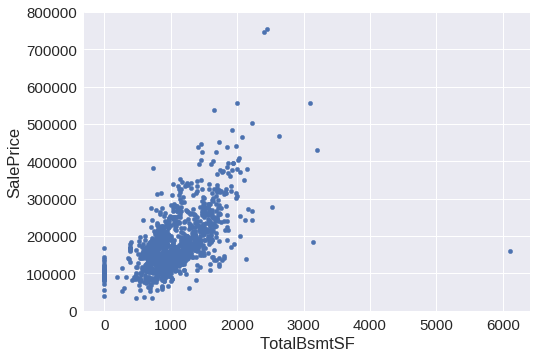

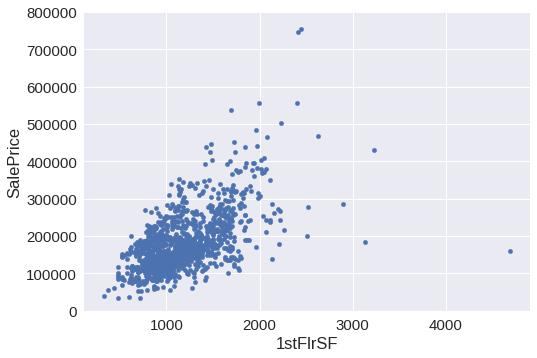

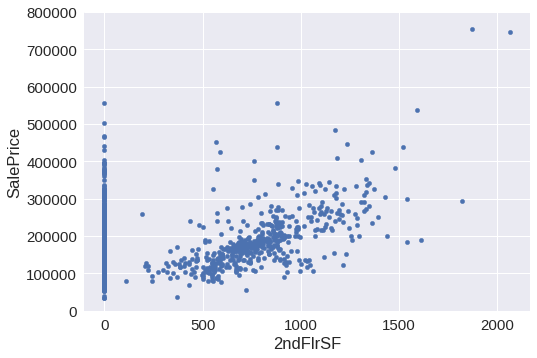

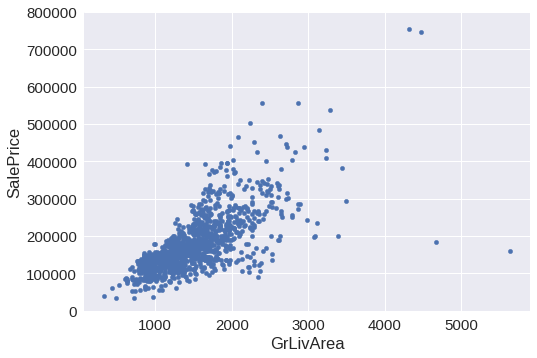

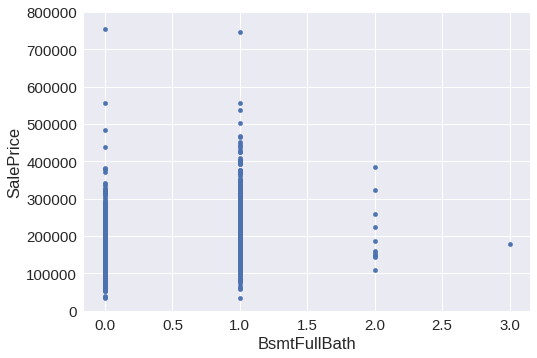

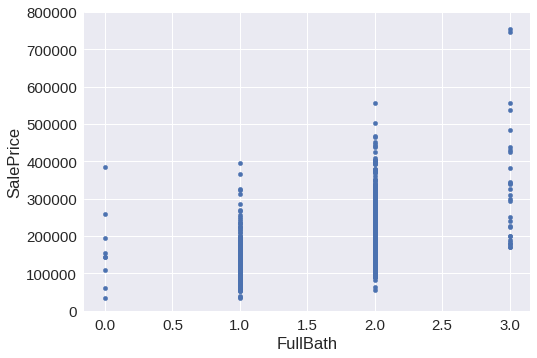

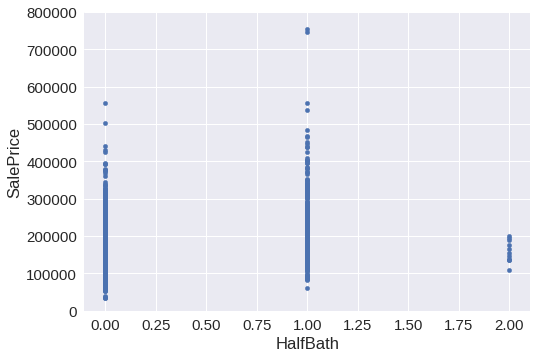

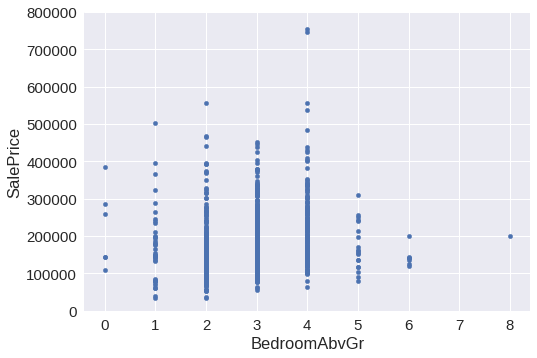

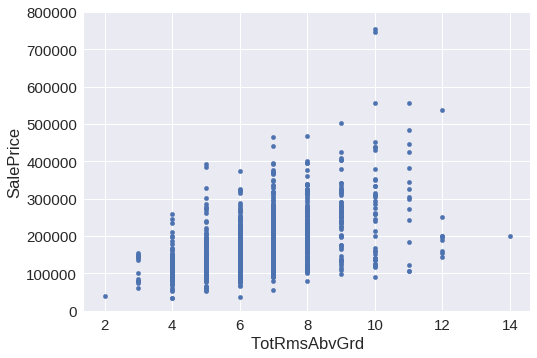

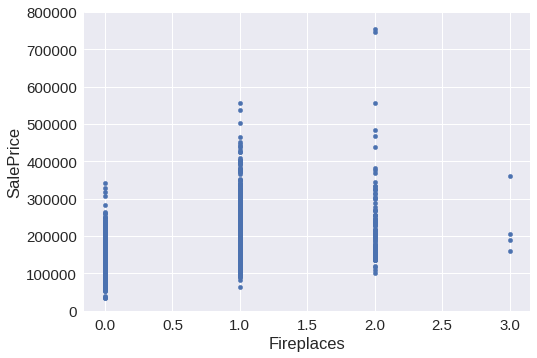

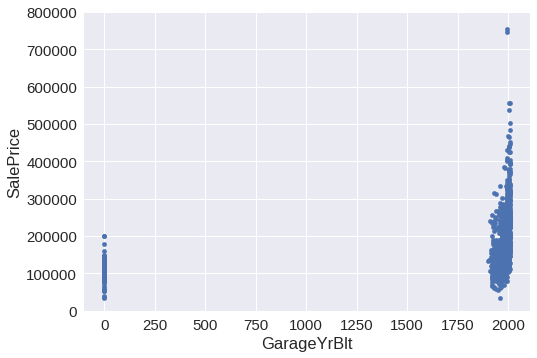

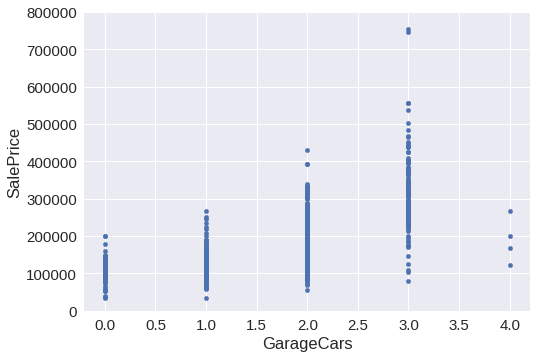

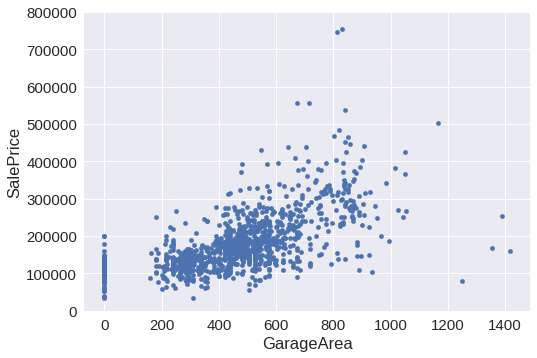

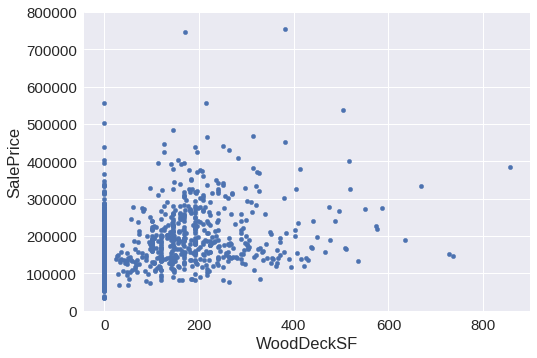

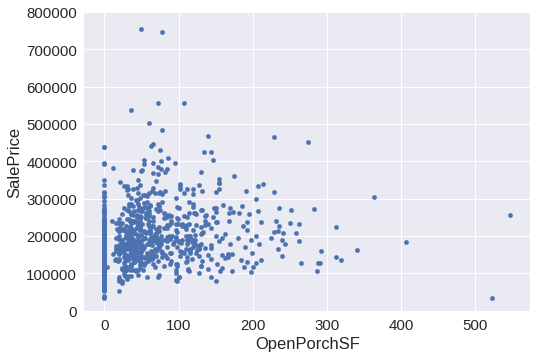

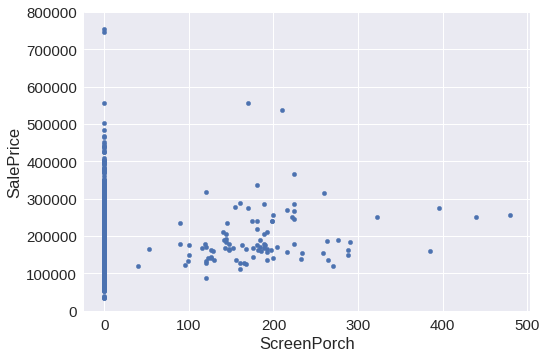

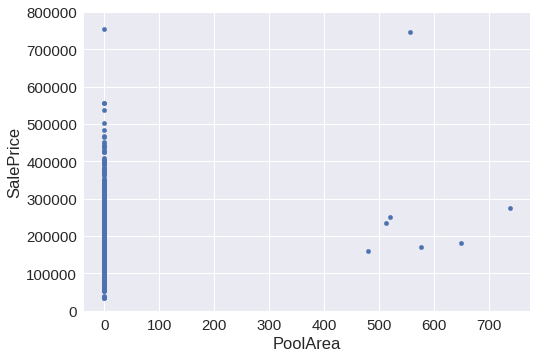

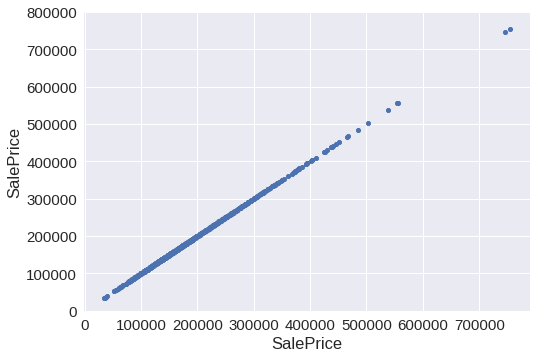

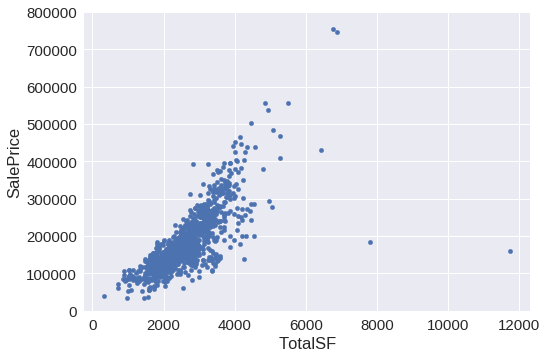

In [74]:
#Bivariate/Multivariate outlier checking with scatter plot
for name in list(train.columns):
    if is_numeric_dtype(train[name]):
        data = pd.concat([train['SalePrice'], train[name]], axis=1)
        data.plot.scatter(x=name, y='SalePrice', ylim=(0,800000))